In [1]:
# align binned to eeg single recording

# decode EEG state and Phase using spike data

In [246]:
from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_derived_generic, get_fig_dir
from binit.bin import which_bin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [ ]:
# Similarity map
# UMAP
# Intrinsic Dimentionality in EEG States
# Decode EEG State using pop & single units
# Compare performance of single units and population

In [26]:
def get_state_piv(spikes, eeg, state_col="state", index_name="bin", eeg_time_col="timepoint_s"):
    spikes = spikes.copy()
    return (
        spikes
        .reset_index()
        .assign(eeg_time = lambda x: which_bin(x[index_name].values, eeg[eeg_time_col].values, time_before=0, time_after=2))
        .merge(eeg, left_on="eeg_time", right_on=eeg_time_col)
        .set_index(index_name)
        [list(spikes.columns) + [state_col]]
    )

In [247]:
outdir = get_fig_dir() / "eeg"
outdir.mkdir(exist_ok=True, parents=True)

In [187]:
from sklearn.base import clone

class EEGDecoder:
    def __init__(self, sh, eeg, estimator, cv=None, scoring="f1_macro", nboot=75, filter_active=True):
        self.df = get_state_piv(
            sh.binned_piv,
            eeg=eeg, 
            state_col="state", 
            index_name="bin", 
            eeg_time_col="timepoint_s"
            )
        self.filter_active = filter_active
        if self.filter_active:
            self.df = self._filter_active(self.df.copy())
        self.nboot = nboot
        self.estimator = estimator
        self.cv = cv if cv is not None else {}
        self.scoring = scoring
    
    def get_real_scores(self):
        df1 = self.df.copy()
        state = df1.pop("state")
        le = LabelEncoder()
        y = le.fit_transform(state)
        X = df1.values
        self.scores_ = cross_val_score(
            self.estimator, 
            X, 
            y, 
            cv=self.cv, 
            scoring=self.scoring
            )
        return self.scores_
    
    def get_unit_scores(self):
        df1 = self.df.copy()
        state = df1.pop("state")
        le = LabelEncoder()
        y = le.fit_transform(state)
        X = df1.values
        out = {}
        for i, n in enumerate(df1.columns):
            out[n] = cross_val_score(
                self.estimator, 
                X[:, i].reshape(-1, 1), 
                y, 
                cv=self.cv, 
                scoring=self.scoring
            )
        return out

    
    def get_bootstrap_scores(self):
        reps = []
        for _ in tqdm(range(self.nboot)):
            X, y = self._shuffle(self.df)
            le = LabelEncoder()
            y = le.fit_transform(y)
            reps.append(cross_val_score(
                clone(self.estimator), 
                X, 
                y, 
                cv=self.cv, 
                scoring=self.scoring
            ))
        return np.vstack(reps)

    
    @staticmethod
    def _filter_active(df):
        idx = np.argwhere((df.sum(axis=1) > 5).values).ravel()
        return df.iloc[idx]
    
    @staticmethod
    def _shuffle(df):
        df1 = df.copy()
        y = df1.pop("state")
        X = df1.apply(np.random.permutation).values
        return X, y




In [189]:
def eeg_decode(
    sessions,
    eeg_states,
    estimator,
    cv=None,
    t_start = 0,
    t_stop = 1798,
    bin_size = 2,
    block = "pre",
    nboot = 75,
    ):
    pop_frames = []
    unit_frames = []
    for session in sessions:
        print(session)
        sh = SpikesHandler(
            block=block, 
            bin_width=bin_size, 
            session_names=[session],
            t_start=t_start, 
            t_stop=t_stop
        )
        eeg_sub = eeg_states.query(f"session_name == '{session}'")
        decoder = EEGDecoder(
            sh, eeg_sub, cv=cv, estimator=estimator, nboot=nboot
        )
        true = np.mean(decoder.get_real_scores())
        reps = decoder.get_bootstrap_scores()
        
        shuffle = np.mean(reps, axis=1).mean()
        pop_frames.append(pd.DataFrame({"true": true, "shuffle": shuffle, "session_name": session},
        index=[0]))
        unit_scores = decoder.get_unit_scores()
        unit_frame = pd.DataFrame(unit_scores).mean().to_frame("F1 Score").reset_index().rename(columns=dict(index="neuron_id"))
        unit_frames.append(unit_frame)

    return pd.concat(pop_frames).reset_index(drop=True), pd.concat(unit_frames).reset_index(drop=True)

In [206]:
eeg_states = (
    load_derived_generic("eeg_states.csv")
    .rename(columns={"cluster": "state"})
    .loc[lambda x: x.quality != "poor"]
)


neurons = (
    load_derived_generic("clusters.csv")
    .merge(load_derived_generic("burst_features.csv"))
    [["neuron_id", "session_name", "wf_3"]]
)
sessions = neurons[["session_name"]].merge(eeg_states)["session_name"].unique()



pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV()
)
cv = StratifiedKFold(shuffle=True)

pop, unit = eeg_decode(
    sessions=sessions,
    eeg_states=eeg_states,
    estimator=pipe, 
    cv=cv, 
    bin_size=1,
    nboot=50,
    )


ESHOCK_03_LOC1


  0%|          | 0/50 [00:00<?, ?it/s]

ESHOCK_04_LOC1


  0%|          | 0/50 [00:00<?, ?it/s]

ESHOCK_06_LOC1


  0%|          | 0/50 [00:00<?, ?it/s]

ESHOCK_07_LOC1


  0%|          | 0/50 [00:00<?, ?it/s]

ESHOCK_08_LOC1


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/50 [00:00<?, ?it/s]

ESHOCK_09_LOC1


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/50 [00:00<?, ?it/s]

hamilton_10


  0%|          | 0/50 [00:00<?, ?it/s]

hamilton_03


  0%|          | 0/50 [00:00<?, ?it/s]

hamilton_04


  0%|          | 0/50 [00:00<?, ?it/s]

hamilton_09


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/50 [00:00<?, ?it/s]

acute_15


  0%|          | 0/50 [00:00<?, ?it/s]

acute_16


  0%|          | 0/50 [00:00<?, ?it/s]

acute_14


  0%|          | 0/50 [00:00<?, ?it/s]

acute_12


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/50 [00:00<?, ?it/s]

acute_11


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

  0%|          | 0/50 [00:00<?, ?it/s]

[Text(0, 0, 'Shuffle'), Text(1, 0, 'Observed')]

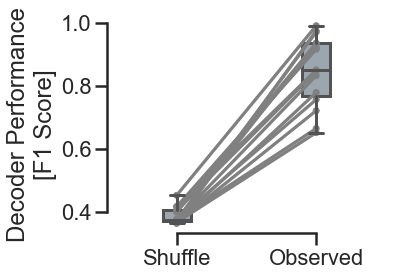

In [221]:
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="poster", style="ticks")

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
df1 =  pop.melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax1, boxplot=True,
               colors=['grey', 'grey', 'grey']
               )
ax1.set_xlabel(None)
ax1.set_ylabel("Decoder Performance\n[F1 Score]")
ax1.set_xticklabels(["Pop\nShuffled", "Pop\nObserved"])

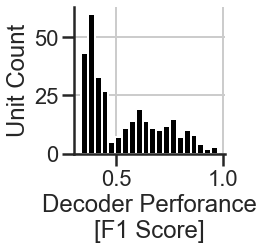

In [261]:

_, ax = plt.subplots(figsize=(4, 4))
unit["F1 Score"].hist(color="black", ax=ax, bins=20)
sns.despine()
ax.set_xlabel("Decoder Perforance\n[F1 Score]")
ax.set_ylabel("Unit Count")
plt.tight_layout()
plt.savefig(outdir / "Unit Dist.png", dpi=300, transparent=True)

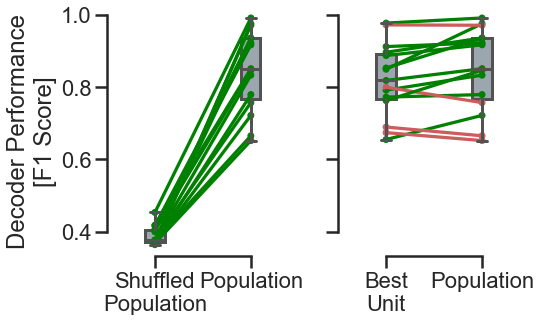

In [262]:
df = (
    unit.merge(neurons)
    .groupby("session_name")["F1 Score"]
    .max()
    .to_frame("best_neuron")
    .reset_index()
    .merge(pop)
)

fig, ax = plt.subplots(ncols=2, figsize=(8, 5), sharey=True)

ax0 = ax[0]
df1 =  pop.melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax0, boxplot=True,
            #    colors=['grey', 'grey', 'grey']
               )
ax0.set_xlabel(None)
ax0.set_ylabel("Decoder Performance\n[F1 Score]")
ax0.set_xticklabels(["Shuffled\nPopulation", "Population"])


ax1 = ax[1]
df1 =  df.drop("shuffle", axis=1).melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax1, boxplot=True,
            #    colors=['grey', 'grey', 'grey']
               )
ax1.set_xlabel(None)
ax1.set_ylabel("Decoder Performance\n[F1 Score]")
ax1.set_xticklabels(["Best\nUnit", "Population"])

plt.tight_layout()
# plt.savefig(outdir / "decoder compare.png", dpi=300, transparent=True)

In [237]:
from scipy.stats import wilcoxon

wilcoxon(df["true"], df["best_neuron"])

WilcoxonResult(statistic=23.0, pvalue=0.03533935546875)